# Data Pre-processing

*(Dated: 02/28/18; following data preparation [notebook](https://github.com/Mipanox/Bird_cocktail/blob/master/notebooks/data_preparation.ipynb))*

In this notebook, we illustrate the steps involved in pre-processing data. In short, the audios are first splitted into segments of fixed lengths (actually a range of lengths), and then transformed into spectrograms. Based on the strength of the features in the spectrogram of each audio segment, an algorithm will decide whether this segment contains (strong enough) signals or there's only noises. The "signals" and "noises" can then be passed to data augmentation and training later

The task requires the [librosa](http://librosa.github.io) audio and music processing package.
<br><br>
<font color="blue">**Note:** This notebook is for demonstration purposes only, to run the codes, refer to the [README](https://github.com/Mipanox/Bird_cocktail#data-pre-processing)</font>

In [17]:
import sys
sys.path.append('../codes/')
from other_util import *

import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
% matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

## 1. Obtaining Spectrograms
In the code, we use the Mel power spectrograms -- power spectrograms (as opposed to magnitude spectrograms) scaled by the [Mel frequency scale](https://en.wikipedia.org/wiki/Mel_scale). Here we show an example Mel power spectrogram for Bewick's Wren:

_(Note: `librosa` also provides options to obtain magnitude spectrograms and/or in linear frequency scale)_

In [18]:
## read in
path = '../datasets/Xeno-Canto/mp3_ca_test/Bewick%27sWren/Bewick%27sWren001.mp3'
sig_orig, sr_orig = librosa.load(path,sr=None)

## resample
sig_orig = librosa.resample(sig_orig, sr_orig, 44100)

## Mel power spectrogram
melspec = librosa.feature.melspectrogram(y=sig_orig, sr=sr_orig)

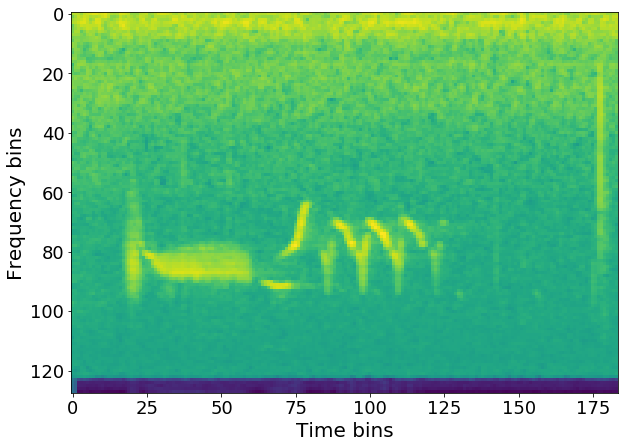

In [9]:
plt.figure(figsize=(12,7))
plt.imshow(melspec[:,:int(melspec.shape[1]/8.)], norm=LogNorm())
plt.xlabel('Time bins'); plt.ylabel('Frequency bins')

## 2. Segmenting Audios
Since every recording varies greatly in length, we must define a reasonable, ideally fixed size for all the data to be fed into the model. A moving window is applied to each recording, and each audio recording is splitted into multiple segments of audios. An example is shown below for the same recording:

_(Note: In practice this step is done BEFORE transforming audios into spectrograms. However, we intentionally reverse the order here for better presentation.)_

In [41]:
multi_spec = getMultiSpec(path, seconds=2, overlap=1.5, minlen=2.)

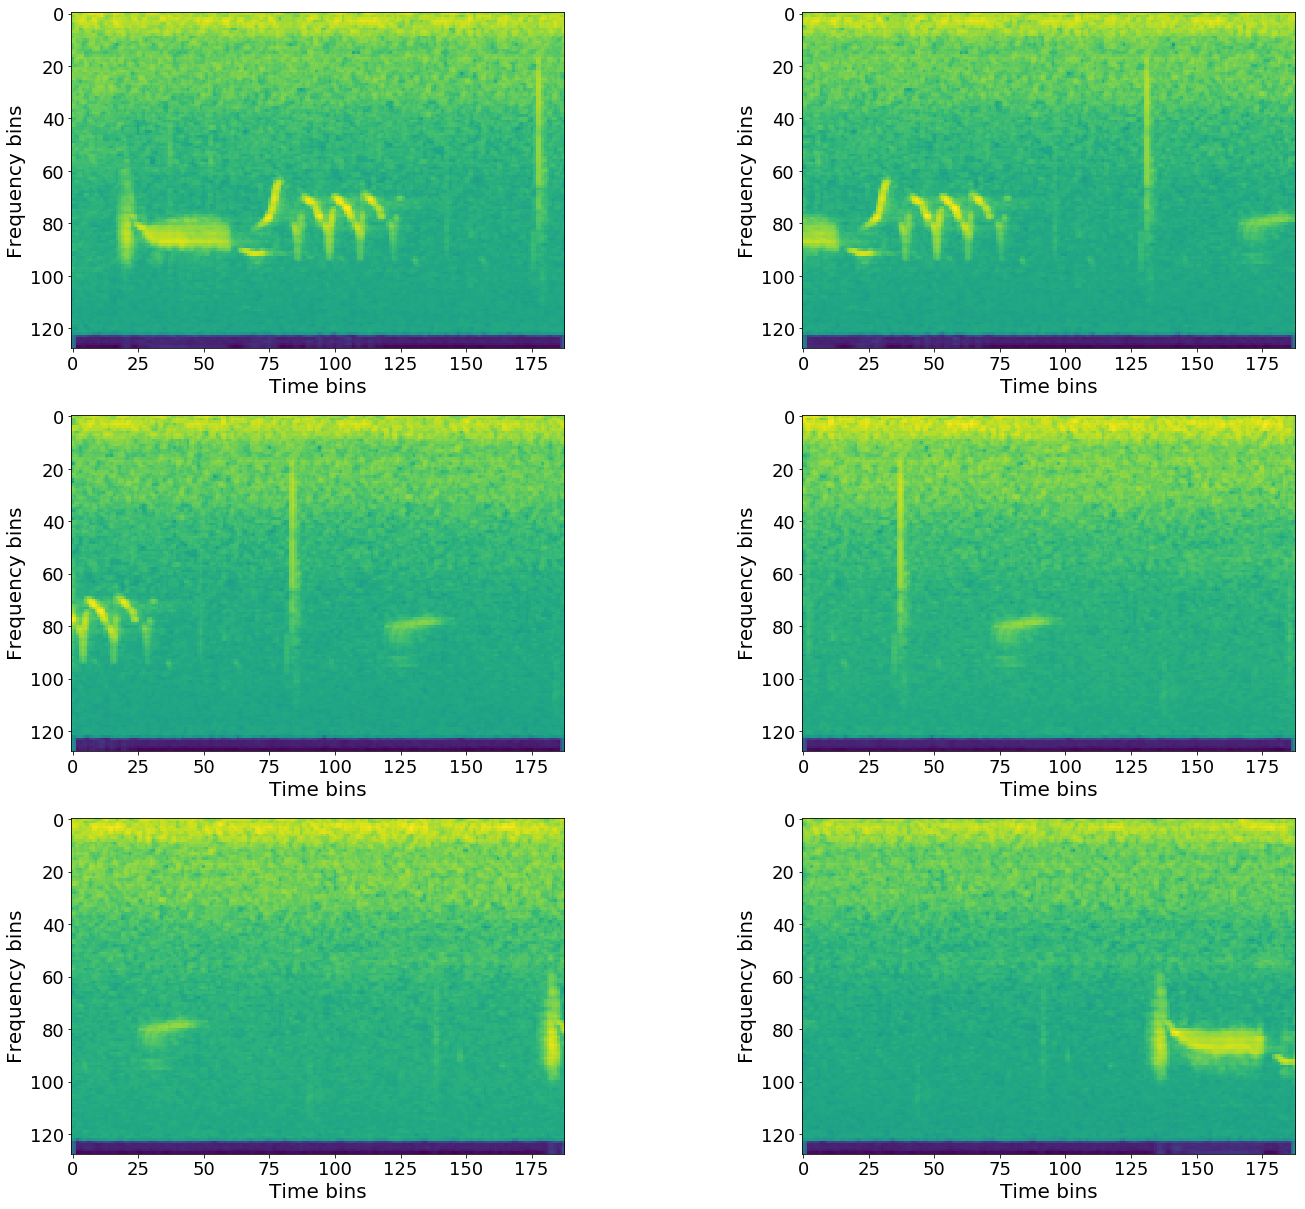

In [42]:
i = 1
plt.figure(figsize=(24,21))
for spec in multi_spec:
    if i > 6: break
    plt.subplot(3,2,i)
    plt.imshow(spec, norm=LogNorm())
    plt.xlabel('Time bins'); plt.ylabel('Frequency bins')
    i += 1

Evidently, these come from the same recording, and are simply different segments of it

## 3. Thresholding
In order to circumvent situations where one segment is "empty" of bird sounds (in the example above, bottom left segment looks like there might only be noises), another algorithm is applied to the spectrograms, and determine if some coherent features are strong enough to be considered "signal". Two examples are shown below -- "accepted" and "rejected" spectrograms respectively

In [56]:
lbt,true  = hasBird(melspec[:,:int(melspec.shape[1]/8.)])
lbf,false = hasBird(melspec[:,1080:1260])

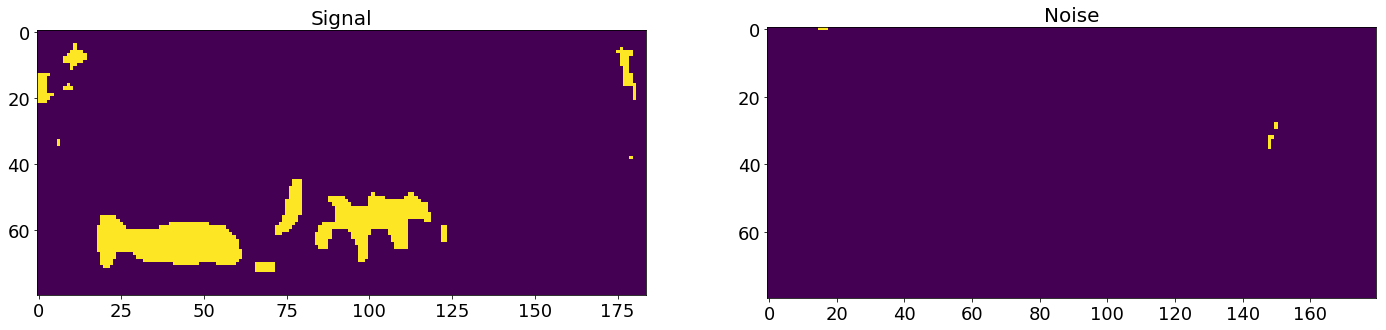

In [57]:
plt.figure(figsize=(24,7))
plt.subplot(121); plt.imshow(true ); plt.title('Signal')
plt.subplot(122); plt.imshow(false); plt.title('Noise')

Clearly, there's significant features in the left panel which are recognized as signals, while the right shows mostly zero (noise) after this processing

_(Note: What you see here is the processed appearances of the spectrograms. They are used only for this thresholding, we still keep the RAW spectrograms and save them as described below)_

## 4. Store Spectrograms
The last piece of the pre-processing is rather simple: Save the passed "signal" spectrograms into corresponding structured folders, and also save the rejected "noisy" spectrograms in another folder, which can be used to augment data in training later